# **The attempt to create predictive model from emotions set**


## **Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import collections
import glob as gb
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/content/drive/MyDrive/DIPLOMA/EngagementWild_2020/OpenFace_features/Engagement_Labels_Engagement.csv', header=None, sep=';').iloc[0:198, 0:2]
labels = labels.dropna(axis=0).drop_duplicates().reset_index()  # there were dupliucated rows
labels.columns = ['index', 'video_name', 'intensity_level']
labels['intensity_level'] = [float(i.replace(',', '.')) for i in labels['intensity_level']]
# labels[70:82]

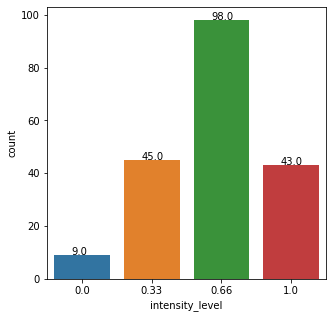

In [3]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x = 'intensity_level', data=labels)

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [5]:
set(labels['intensity_level'])

{0.0, 0.33, 0.66, 1.0}

In [6]:
train_path = '/content/drive/MyDrive/DIPLOMA/fer_video_results/'
val_path = '/content/drive/MyDrive/DIPLOMA/fer_video_results/val/'

train_names = [i.replace(train_path, '').replace('.csv', '') for i in gb.glob(train_path + '*.csv')]
val_names = [i.replace(val_path, '').replace('.csv', '') for i in gb.glob(val_path + '*.csv')]

In [7]:
def make_std_dataset(vid_names, folder_path, labels_df=labels):  # labels is the common csv for both train and val
    cnt = 0
    ord_labels = []
    vid_frames_number = []  # for minimal frames number counter
    for s_name in vid_names:  # iteration over train/val set
        cur = pd.read_csv(folder_path + s_name + '.csv').drop(['box'], axis=1)  # folder_path path to train/val features folder
        # because in FER there was another emotions set order (in AFEW it's: Anger, Disgust, Fear, Happy, Neutral, Sad, Surprise)
        cols = cur.columns.tolist()
        cols = cols = cols[:4] + cols[6:] + cols[4:5] + cols[5:6]
        cur = cur[cols]
        # count of frames number in each video after dropna
        vid_frames_number.append(len(cur))

        # making dataset
        if cnt == 0:
            # create mean dataset
            df = pd.DataFrame(cur.std(), columns=[s_name]).transpose().reset_index()
            cnt+=1
        else:
            # add new rows into dataset
            tmp = pd.DataFrame(cur.std(), columns=[s_name]).transpose().reset_index()
            df = pd.concat((df, tmp))

        lab = labels_df[labels_df['video_name']==s_name]['intensity_level']
        ord_labels.append(float(lab) if not lab.empty else None)
      
    ord_labels = pd.Series(ord_labels)
    ord_labels.fillna(ord_labels.median(), inplace=True)

    print('Minimal frames number in each video', min(vid_frames_number))
    return df, ord_labels

In [8]:
def make_agg_dataset(vid_names, folder_path, labels_df=labels):  # labels is the common csv for both train and val
    cnt = 0
    ord_labels = []
    vid_frames_number = []  # for minimal frames number counter
    for s_name in vid_names:  # iteration over train/val set
        cur = pd.read_csv(folder_path + s_name + '.csv').drop(['box'], axis=1)  # folder_path path to train/val features folder
        # because in FER there was another emotions set order (in AFEW it's: Anger, Disgust, Fear, Happy, Neutral, Sad, Surprise)
        cols = cur.columns.tolist()
        cols = cols = cols[:4] + cols[6:] + cols[4:5] + cols[5:6]
        cur = cur[cols]
        # count of frames number in each video after dropna
        vid_frames_number.append(len(cur))

        # making dataset
        if cnt == 0:
            # create std dataset
            std_df = pd.DataFrame(cur.std(), columns=[s_name]).transpose()
            std_df.rename(columns = {'angry' : 'angry_std', 'disgust' : 'disgust_std',
                                     'fear': 'fear_std', 'happy': 'happy_std',
                                     'neutral': 'neutral_std', 'sad': 'sad_std',
                                     'surprise': 'surprise_std'}, inplace = True)
            mean_df = pd.DataFrame(cur.mean(), columns=[s_name]).transpose()
            mean_df.rename(columns = {'angry' : 'angry_mean', 'disgust' : 'disgust_mean',
                                     'fear': 'fear_mean', 'happy': 'happy_mean',
                                     'neutral': 'neutral_mean', 'sad': 'sad_mean',
                                     'surprise': 'surprise_mean'}, inplace = True)
            min_df = pd.DataFrame(cur.min(), columns=[s_name]).transpose()
            min_df.rename(columns = {'angry' : 'angry_min', 'disgust' : 'disgust_min',
                                     'fear': 'fear_min', 'happy': 'happy_min',
                                     'neutral': 'neutral_min', 'sad': 'sad_min',
                                     'surprise': 'surprise_min'}, inplace = True)
            max_df = pd.DataFrame(cur.max(), columns=[s_name]).transpose()
            max_df.rename(columns = {'angry' : 'angry_max', 'disgust' : 'disgust_max',
                                     'fear': 'fear_max', 'happy': 'happy_max',
                                     'neutral': 'neutral_max', 'sad': 'sad_max',
                                     'surprise': 'surprise_max'}, inplace = True)

            all_features = pd.concat((std_df, mean_df, min_df, max_df), axis=1)
            cnt+=1
        else:
            # add new rows into dataset
            tmp1 = pd.DataFrame(cur.std(), columns=[s_name]).transpose()
            tmp1.rename(columns = {'angry' : 'angry_std', 'disgust' : 'disgust_std',
                                     'fear': 'fear_std', 'happy': 'happy_std',
                                     'neutral': 'neutral_std', 'sad': 'sad_std',
                                     'surprise': 'surprise_std'}, inplace = True)
            tmp2 = pd.DataFrame(cur.mean(), columns=[s_name]).transpose()
            tmp2.rename(columns = {'angry' : 'angry_mean', 'disgust' : 'disgust_mean',
                                     'fear': 'fear_mean', 'happy': 'happy_mean',
                                     'neutral': 'neutral_mean', 'sad': 'sad_mean',
                                     'surprise': 'surprise_mean'}, inplace = True)
            tmp3 = pd.DataFrame(cur.min(), columns=[s_name]).transpose()
            tmp3.rename(columns = {'angry' : 'angry_min', 'disgust' : 'disgust_min',
                                     'fear': 'fear_min', 'happy': 'happy_min',
                                     'neutral': 'neutral_min', 'sad': 'sad_min',
                                     'surprise': 'surprise_min'}, inplace = True)
            tmp4 = pd.DataFrame(cur.max(), columns=[s_name]).transpose()
            tmp4.rename(columns = {'angry' : 'angry_max', 'disgust' : 'disgust_max',
                                     'fear': 'fear_max', 'happy': 'happy_max',
                                     'neutral': 'neutral_max', 'sad': 'sad_max',
                                     'surprise': 'surprise_max'}, inplace = True)

            tmp = pd.concat((tmp1, tmp2, tmp3, tmp4), axis=1)
            all_features = pd.concat((all_features, tmp))

        lab = labels_df[labels_df['video_name']==s_name]['intensity_level']
        ord_labels.append(float(lab) if not lab.empty else None)
      
    ord_labels = pd.Series(ord_labels)
    ord_labels.fillna(ord_labels.median(), inplace=True)

    all_features.fillna(all_features.mean(), inplace=True)

    print('Minimal frames number in each video', min(vid_frames_number))
    return all_features.reset_index(), ord_labels

In [9]:
# x_train, y_train = make_std_dataset(train_names, train_path)
# x_train, y_train = make_mean_dataset(train_names, train_path)
x_train, y_train = make_agg_dataset(train_names, train_path)
x_train

Minimal frames number in each video 1013


,index,angry_std,disgust_std,fear_std,happy_std,neutral_std,sad_std,surprise_std,angry_mean,disgust_mean,...,neutral_min,sad_min,surprise_min,angry_max,disgust_max,fear_max,happy_max,neutral_max,sad_max,surprise_max
0,subject_44_Vid_7,0.046999,0.000494,0.031337,0.049731,0.206647,0.132195,0.031918,0.058819,0.000014,...,0.00,0.00,0.0,0.36,0.03,0.34,0.89,0.99,0.83,0.84
1,subject_57_Vid_7,0.017908,0.000177,0.013056,0.194658,0.180146,0.054301,0.004064,0.032516,0.000003,...,0.00,0.00,0.0,0.36,0.01,0.18,1.00,0.97,0.30,0.29
2,subject_26_Vid_1,0.084349,0.004746,0.019531,0.010446,0.189841,0.157077,0.006902,0.098213,0.000512,...,0.00,0.02,0.0,0.75,0.17,0.36,0.33,0.92,0.92,0.17
3,subject_26_Vid_2,0.107341,0.004675,0.018441,0.010370,0.166206,0.145632,0.006398,0.209927,0.002062,...,0.03,0.02,0.0,0.70,0.06,0.17,0.10,0.96,0.94,0.09
4,subject_26_Vid_3,0.114261,0.002948,0.051549,0.004763,0.207722,0.150128,0.028443,0.133192,0.000523,...,0.01,0.02,0.0,0.86,0.11,0.54,0.14,0.94,0.90,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,subject_41_Vid_7,0.030452,0.000000,0.061148,0.162933,0.148665,0.010202,0.018359,0.039295,0.000000,...,0.06,0.00,0.0,0.67,0.00,0.45,0.93,0.93,0.11,0.36
92,subject_51_Vid_7,0.041828,0.005800,0.028131,0.017003,0.103958,0.082001,0.001073,0.113601,0.005751,...,0.05,0.06,0.0,0.55,0.03,0.21,0.71,0.79,0.76,0.03
93,subject_58_Vid_7,0.072582,0.001977,0.077920,0.112730,0.174258,0.104430,0.039257,0.128575,0.000157,...,0.02,0.03,0.0,0.75,0.05,0.44,0.56,0.68,0.64,0.23
94,subject_59_Vid_7,0.037817,0.000658,0.025543,0.045231,0.137980,0.101363,0.009810,0.055476,0.000029,...,0.07,0.01,0.0,0.37,0.03,0.32,0.75,0.98,0.81,0.44


In [10]:
X_val, y_val = make_agg_dataset(val_names, val_path)
# X_val, y_val = make_mean_dataset(val_names, val_path)
# X_val, y_val = make_std_dataset(val_names, val_path)
X_val

Minimal frames number in each video 5723


,index,angry_std,disgust_std,fear_std,happy_std,neutral_std,sad_std,surprise_std,angry_mean,disgust_mean,...,neutral_min,sad_min,surprise_min,angry_max,disgust_max,fear_max,happy_max,neutral_max,sad_max,surprise_max
0,subject_12_Vid_6,0.069988,0.000992,0.042666,0.124515,0.232532,0.094954,0.035563,0.055152,0.000051,...,0.00,0.00,0.0,0.67,0.06,0.42,0.99,0.97,0.63,0.49
1,subject_6_Vid_6,0.079603,0.003594,0.066513,0.055514,0.203570,0.124501,0.098281,0.125960,0.001037,...,0.01,0.00,0.0,0.63,0.05,0.57,0.98,0.96,0.72,0.81
2,subject_13_Vid_6,0.027531,0.002555,0.019417,0.102962,0.143041,0.030670,0.024188,0.031289,0.000199,...,0.05,0.00,0.0,0.39,0.15,0.30,0.89,0.98,0.40,0.57
3,subject_4_Vid_6,0.010159,0.000000,0.007579,0.154840,0.162022,0.027292,0.005489,0.005544,0.000000,...,0.00,0.00,0.0,0.25,0.00,0.09,1.00,1.00,0.39,0.15
4,subject_2_Vid_6,0.026469,0.000104,0.009088,0.065380,0.095887,0.034152,0.004473,0.024607,0.000001,...,0.03,0.01,0.0,0.78,0.01,0.15,0.66,0.98,0.59,0.07
5,subject_11_Vid_6,0.036577,0.000784,0.027143,0.126468,0.165495,0.034760,0.043949,0.045532,0.000058,...,0.02,0.00,0.0,0.36,0.02,0.48,0.95,0.97,0.38,0.65
6,subject_5_Vid_6,0.056228,0.001105,0.022155,0.115559,0.162222,0.088793,0.005214,0.115323,0.000082,...,0.04,0.00,0.0,0.63,0.03,0.24,0.94,0.88,0.77,0.10
7,subject_17_Vid_6,0.101614,0.007946,0.039804,0.262512,0.166526,0.094460,0.033741,0.170181,0.003945,...,0.00,0.00,0.0,0.66,0.11,0.33,1.00,0.89,0.55,0.39
8,subject_16_Vid_6,0.115444,0.003170,0.032204,0.065040,0.236862,0.112766,0.014893,0.185212,0.001027,...,0.01,0.01,0.0,0.61,0.03,0.22,0.88,0.94,0.81,0.29
9,subject_24_Vid_5,0.054519,0.001822,0.028315,0.057568,0.146521,0.069916,0.008144,0.067301,0.000215,...,0.01,0.00,0.0,0.53,0.04,0.26,0.96,0.97,0.57,0.19


## **ML PART**

In [11]:
!pip install mord

  Created wheel for mord: filename=mord-0.6-py3-none-any.whl size=6006 sha256=8e699935516a69c6e56d03e995bea2f2a33e29c8703e22be72149841ec72eee0
  Stored in directory: /root/.cache/pip/wheels/80/1d/8a/bef1a01b6a3c91494905d161d5426c181819f9730a773141eb
Successfully built mord


In [12]:
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifier, LogisticRegression, Lasso
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from mord import OrdinalRidge, LogisticAT, LogisticIT, LAD

import numpy as np

In [13]:
def print_metrics(y_test, y_pred):
    print(f'mean_squared_error_score:    {mean_squared_error(y_test, y_pred)}')
    print(f'r2_score:                    {r2_score(y_test, y_pred)}')

In [14]:
def draw_conf_matrix(y_true_fl, y_pred):
    level = sorted(list(set(labels['intensity_level'])))
    print(level)
    y_pred_round = []
    for y in y_pred:
        y_pred_round.append([str(i) for i in level if abs(y - i) == min(abs(y - j) for j in level)][0])

    # y_pred_round

    cm = confusion_matrix(y_true_fl.astype(str), y_pred_round)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=level)
    disp.plot()

In [15]:
X_train = x_train.drop('index', axis=1)
y_train_fl = y_train  # regression
y_train_bin = y_train.replace([0, 0.33, 0.66, 1], [-1, -1, 1, 1]).astype(int)  # binary classification
y_train = y_train.replace([0, 0.33, 0.66, 1], [0, 1, 2, 3]).astype(int)  # multi-class classification


X_test = X_val.drop('index', axis=1)
y_test_fl = y_val  # regression
y_test_bin = y_val.replace([0, 0.33, 0.66, 1], [-1, -1, 1, 1]).astype(int)  # binary classification
y_test = y_val.replace([0, 0.33, 0.66, 1], [0, 1, 2, 3]).astype(int)  # multi-class classification

<Figure size 1080x1080 with 0 Axes>

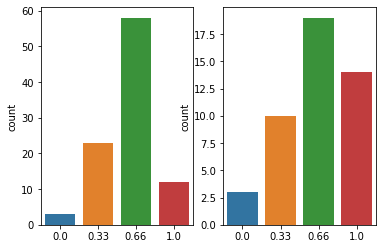

In [16]:
plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(1, 2)

sns.countplot(x=y_train_fl, ax=axes[0])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

sns.countplot(x=y_test_fl, ax=axes[1])
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
kf = KFold(n_splits=5, shuffle=True)

In [ ]:
# scaler = StandardScaler()
# X_train_norm = scaler.fit_transform(X_train)
# X_test_norm = scaler.transform(X_test)

X_train_norm = normalize(X_train, norm='l2')
X_test_norm = normalize(X_test, norm='l2')

**RIDGE**

In [ ]:
clf = Ridge(alpha=10, max_iter=10000, solver='svd')
clf.fit(X_train, y_train_fl)
y_pred = clf.predict(X_test)

print_metrics(y_test_fl, y_pred)

mean_squared_error_score:    0.08311930765403358
r2_score:                    0.04611246278972292


[0.0, 0.33, 0.66, 1.0]


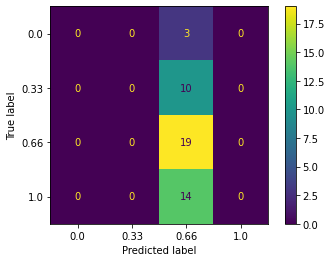

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

**Random Forest**

In [ ]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=10, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train_fl)
y_pred = clf.predict(X_test)
print_metrics(y_test_fl, y_pred)
clf.oob_score_

mean_squared_error_score:    0.08174157891207559
r2_score:                    0.06192344959534213


0.09707449017571812

[0.0, 0.33, 0.66, 1.0]


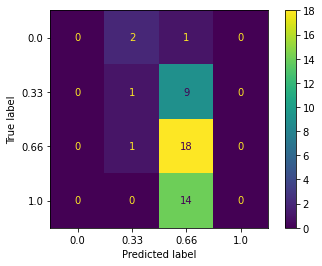

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

**SVC**

In [ ]:
import pickle

In [ ]:
clf = svm.SVR(kernel='rbf')
clf.fit(X_train, y_train_fl)
y_pred = clf.predict(X_test)
print_metrics(y_test_fl, y_pred)

mean_squared_error_score:    0.0745163991549208
r2_score:                    0.14484051325930403


[0.0, 0.33, 0.66, 1.0]


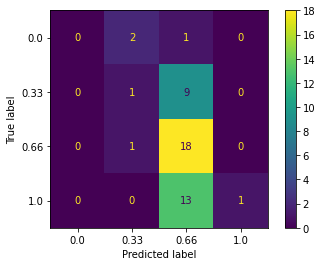

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

In [ ]:
fname = 'SVC_rbf_model'
pickle.dump(clf, open(fname, 'wb'))

### **MORD**

In [ ]:
clf = OrdinalRidge(alpha=0.5)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print_metrics(y_test_fl, pd.Series(y_pred).replace([1, 2, 3], [0.33, 0.66, 1]))

mean_squared_error_score:    0.07054782608695655
r2_score:                    0.19038435255349173


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but OrdinalRidge was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
y_pred = pd.Series(y_pred).replace([1, 2, 3], [0.33, 0.66, 1])

[0.0, 0.33, 0.66, 1.0]


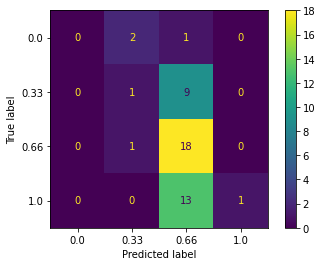

In [ ]:
draw_conf_matrix(y_test_fl, y_pred)

### **With research interest the task can be transformed to binary classification problem**

In [ ]:
def print_metrics(y_test, y_pred):
    print(f'f1_score:                    {f1_score(y_test, y_pred, average="macro")}')
    print(f'precision_score:             {precision_score(y_test, y_pred, average="macro").round(2)}')
    print(f'recall_score:                {recall_score(y_test, y_pred, average="macro").round(2)}')
    print(f'accuracy_score:              {accuracy_score(y_test, y_pred).round(2)}')
    print(f'balanced_accuracy_score:     {balanced_accuracy_score(y_test, y_pred).round(2)}')

In [ ]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()

**Logistic regression**

In [ ]:
lr = LogisticRegression(random_state=17, class_weight = "balanced")

model = lr.fit(X_train_norm, y_train_bin)
y_pred = model.predict(X_test_norm)

print_metrics(y_test_bin, y_pred)

f1_score:                    0.5511042629686698
precision_score:             0.56
recall_score:                0.57
accuracy_score:              0.59
balanced_accuracy_score:     0.57


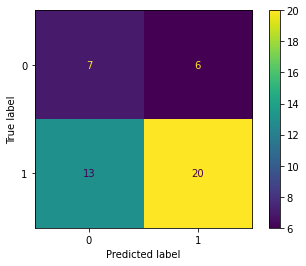

In [ ]:
conf_matrix(y_test_bin, y_pred)

**Random Forest**

In [ ]:
clf = RandomForestClassifier(n_estimators=10000, criterion = 'entropy', max_depth=10, n_jobs=-1, oob_score=True)

clf.fit(X_train_norm, y_train_bin)
y_pred = clf.predict(X_test_norm)
print_metrics(y_test_bin, y_pred)
clf.oob_score_

f1_score:                    0.6031372549019608
precision_score:             0.76
recall_score:                0.6
accuracy_score:              0.76
balanced_accuracy_score:     0.6


0.7291666666666666

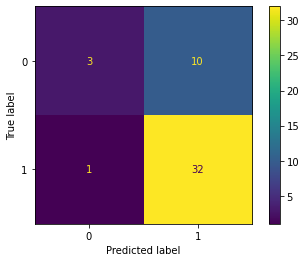

In [ ]:
conf_matrix(y_test_bin, y_pred)